# Introduction


In this notebook, we use [TensorFlow Lite](https://www.tensorflow.org/lite/models/object_detection/overview) to prepare a custom model on your own dataset for low-end (e.g. mobile) devices. It takes three steps:

1.   Import our dataset
2.   Train a TensorFlow2 Object Detection Model
3.   Convert the model to TensorFlow Lite

This file is based on a notebook from Roboflow.

In [151]:
# check GPU configuration
!nvidia-smi

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Fri Jan 15 19:47:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+-------------------

# 1. Import

## Prepare Data

Data was prepaired using scripts, rather than the Roboflow tool/API.

The scripts will take xml labels and jpg images and produce a `.tfrecords` file.

images/xml -> generate_csv.py -> generate_pbtxt.py -> generate_tfrecord.py

### Upload dataset

The dataset was prepared locally and uploaded to roboflow for preprocessing.

It should unzip into two directories `test/` and `train/`.

In [160]:
!cd /content/test
!curl -L "https://app.roboflow.com/ds/mjbUSknb0u?key=a3S98x6vcl" > roboflow.zip; unzip roboflow.zip

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
chdir: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/bin/bash: roboflow.zip: No such file or directory
unzip:  cannot find or open roboflow.zip, roboflow.zip.zip or roboflow.zip.ZIP.


# 2. Train

_Note that this section is based on the [MobileNetSSDv2 Notebook](https://colab.research.google.com/drive/1wTMIrJhYsQdq_u7ROOkf0Lu_fsX5Mu8a). This is because TensorFlow Lite is independent of the model used, so we're picking a simple and lightweight solution._

## **Training MobileNetSSD Object Detection on a Custom Dataset**

💡 Recommendation: [Open this blog post](https://blog.roboflow.ai/training-a-tensorflow-object-detection-model-with-a-custom-dataset/) to continue.

### **Overview**

This notebook walks through how to train a MobileNet object detection model using the TensorFlow 1.5 Object Detection API.

**Credit to [DLology](https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/) and [Tony607](https://github.com/Tony607)**, whom wrote the first notebook on which much of this is example is based. 

### **Our Model**

We'll be training a MobileNetSSDv2 (single shot detector). This specific model is a one-short learner, meaning each image only passes through the network once to make a prediction, which allows the architecture to be very performant for mobile hardware.

The model arechitecture is one of many available via TensorFlow's [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models).

As a note, this notebook presumes TensorFlow 1.5 as TensorFlow 2.0 has yet to fully support the object detection API.

### **Inference**

We'll run inference directly in this notebook, and on the test images contained in the "test" folder from our GitHub repo. 

When adapting to your own dataset, you'll need to add test images to the `test` folder located at `tensorflow-object-detection/test`.







## Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [161]:
# If you forked the repo, you can replace the link.
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.
num_steps = 100000  # 200000 to improve

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    },    
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [162]:
# use TF 1.x for Object Detection APIs as they are not ported to TF 2.0 yet
%tensorflow_version 1.x

## Clone the `tensorflow-object-detection` repository or your fork.

In [163]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-163-1ba76453ccec>", line 3, in <module>
    get_ipython().magic('cd /content')
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-91>", line 2, in cd
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magics/osm.py", line 288, in cd
    oldcwd = py3compat.getcwd()
FileNotFoundError: [Errno 2] No such file or directory

During handling of the above exception, anothe

FileNotFoundError: ignored

## Install required packages

In [129]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!pip install tf_slim

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research


shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


## Prepare `tfrecord` files

Roboflow automatically creates our TFRecord and label_map files that we need!

**Generating your own TFRecords the only step you need to change for your own custom dataset.**

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll create two separate datasets in Roboflow and generate one set of TFRecords for each.

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [130]:
%cd /content/tensorflow-object-detection-faster-rcnn/data

/content/tensorflow-object-detection-faster-rcnn/data


In [131]:
# training set
%ls /content/tensorflow-object-detection-faster-rcnn/data/train/

Cereal-Boxes_label_map.pbtxt    IMG_20210113_134232192_HDR.xml
Cereal-Boxes.tfrecord           IMG_20210113_134234368_HDR.jpg
IMG_20210113_134151190_HDR.jpg  IMG_20210113_134234368_HDR.xml
IMG_20210113_134151190_HDR.xml  IMG_20210113_134240517_HDR.jpg
IMG_20210113_134154132_HDR.jpg  IMG_20210113_134240517_HDR.xml
IMG_20210113_134154132_HDR.xml  IMG_20210113_134242319_HDR.jpg
IMG_20210113_134155480_HDR.jpg  IMG_20210113_134242319_HDR.xml
IMG_20210113_134155480_HDR.xml  IMG_20210113_134243028_HDR.jpg
IMG_20210113_134156610_HDR.jpg  IMG_20210113_134243028_HDR.xml
IMG_20210113_134156610_HDR.xml  IMG_20210113_134245896_HDR.jpg
IMG_20210113_134211767_HDR.jpg  IMG_20210113_134245896_HDR.xml
IMG_20210113_134211767_HDR.xml  IMG_20210113_134247292_HDR.jpg
IMG_20210113_134213388_HDR.jpg  IMG_20210113_134247292_HDR.xml
IMG_20210113_134213388_HDR.xml  IMG_20210113_134248691_HDR.jpg
IMG_20210113_134214414_HDR.jpg  IMG_20210113_134248691_HDR.xml
IMG_20210113_134214414_HDR.xml  IMG_20210113_134250512_

In [132]:
# test set
%ls /content/tensorflow-object-detection-faster-rcnn/data/test

Cereal-Boxes_label_map.pbtxt    IMG_20210113_134303881.jpg
Cereal-Boxes.tfrecord           IMG_20210113_134303881.xml
IMG_20210113_134153083_HDR.jpg  IMG_20210113_134311640.jpg
IMG_20210113_134153083_HDR.xml  IMG_20210113_134311640.xml
IMG_20210113_134231142_HDR.jpg  IMG_20210113_134718207.jpg
IMG_20210113_134231142_HDR.xml


In [133]:
test_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/test/Cereal-Boxes.tfrecord'
train_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/test/Cereal-Boxes.tfrecord'
label_map_pbtxt_fname = '/content/tensorflow-object-detection-faster-rcnn/data/test/Cereal-Boxes_label_map.pbtxt'

## Download base model

In [134]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [135]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 28 root   root  4.0K Jan 15 19:45 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [136]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [137]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [138]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [139]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [140]:
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 13
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect

In [141]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
# !rm -rf {model_dir}
# os.makedirs(model_dir, exist_ok=True)

## Run Tensorboard(Optional)

In [142]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2021-01-15 19:45:41--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.232.108.170, 3.224.49.7, 52.3.118.132, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.232.108.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.4’

ngrok-stable-linux- 100%[===================>]  13.13M  50.5MB/s    in 0.3s    

2021-01-15 19:45:42 (50.5 MB/s) - ‘ngrok-stable-linux-amd64.zip.4’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [143]:
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [144]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [145]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://21de3f5b212e.ngrok.io


## Train the model

In [146]:
!pip install lvis
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0115 19:45:53.212644 140675679090560 model_lib.py:793] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 100000
I0115 19:45:53.212856 140675679090560 config_util.py:552] Maybe overwriting train_steps: 100000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0115 19:45:53.212975 140675679090560 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0115 19:45:53.213058 140675679090560 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0115 19:45:53.213150 140675679090560 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0115 19:45:53.213272 140675679090560 model_lib.py:809] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_

In [ ]:
!ls {model_dir}

checkpoint				     graph.pbtxt
events.out.tfevents.1610735297.6dd4fddaef54  model.ckpt-0.data-00000-of-00001
events.out.tfevents.1610735491.6dd4fddaef54  model.ckpt-0.index
events.out.tfevents.1610737581.6dd4fddaef54  model.ckpt-0.meta


## Exporting Trained Inference Graphs
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. We do this again for TFLite. This can be done as follows:

In [ ]:
%cd /content/models/research

import re
import numpy as np

output_directory = './fine_tuned_model'
tflite_directory = './fine_tuned_model/tflite'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={tflite_directory} \
    --trained_checkpoint_prefix={last_model_path}

/content/models/research
training/model.ckpt-100000
Instructions for updating:
Please use `layer.__call__` method instead.
W0815 20:22:10.045596 140696785893248 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0815 20:22:11.980888 140696785893248 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0815 20:22:12.016239 140696785893248 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0815 20:22:12.145587 140696785893248 convolutional_box_predictor.py:156] depth of additional conv before box predic

In [ ]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta   tflite
model.ckpt.data-00000-of-00001	pipeline.config


## Download the model `.pb` file

In [ ]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
print(pb_fname)
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

/content/models/research/fine_tuned_model/frozen_inference_graph.pb


In [ ]:
# !ls -alh {pb_fname}

### Option1 : upload the `.pb` file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [ ]:
# # Install the PyDrive wrapper & import libraries.
# # This only needs to be done once in a notebook.
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials


# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# fname = os.path.basename(pb_fname)
# # Create & upload a text file.
# uploaded = drive.CreateFile({'title': fname})
# uploaded.SetContentFile(pb_fname)
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

### Option2 :  Download the `.pb` file directly to your local file system
This method may not be stable when downloading large files like the model `.pb` file. Try **option 1** instead if not working.

In [ ]:
# from google.colab import files
# files.download(pb_fname)

### OPTIONAL: Download the `label_map.pbtxt` file

In [ ]:
# from google.colab import files
# files.download(label_map_pbtxt_fname)

### OPTIONAL: Download the modified pipline file
If you plan to use OpenVINO toolkit to convert the `.pb` file to inference faster on Intel's hardware (CPU/GPU, Movidius, etc.)

In [ ]:
# files.download(pipeline_fname)

In [ ]:
# !tar cfz fine_tuned_model.tar.gz fine_tuned_model
# from google.colab import files
# files.download('fine_tuned_model.tar.gz')

## Run inference test
Test with images in repository `tensorflow-object-detection/test` directory.

**To test with your own images, you need to place your images inside the `test` directory in this Colab notebook!** More on this below.

In [ ]:
!cp -r /content/test/test/ /content/tensorflow-object-detection-faster-rcnn/

In [ ]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "test")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/tensorflow-object-detection-faster-rcnn/test/BloodImage_00284_jpg.rf.e7cb6ae3c32ea283e01013306841ebe9.jpg', '/content/tensorflow-object-detection-faster-rcnn/test/BloodImage_00038_jpg.rf.586cdd437b7131d945dd3863b251f839.jpg', '/content/tensorflow-object-detection-faster-rcnn/test/BloodImage_00227_jpg.rf.47dc96ab3ba700e6833178f5c9fb9d2d.jpg', '/content/tensorflow-object-detection-faster-rcnn/test/BloodImage_00289_jpg.rf.e91d1b782364ecf3ed193747239fc30b.jpg', '/content/tensorflow-object-detection-faster-rcnn/test/BloodImage_00275_jpg.rf.cc9f95930d7bb572770f05644effb883.jpg', '/content/tensorflow-object-detection-faster-rcnn/test/BloodImage_00337_jpg.rf.8edf952279f4efa47a58a1305bc5b442.jpg', '/content/tensorflow-object-detection-faster-rcnn/test/BloodImage_00090_jpg.rf.dfe98500a0f6762c105fc595d60999d8.jpg', '/content/tensorflow-object-detection-faster-rcnn/test/BloodImage_00062_jpg.rf.ad52c678dfb540b95e1b31b49a4bca42.jpg', '/content/tensorflow-object-detection-faster-rcnn/test/

In [ ]:
!ls /content/tensorflow-object-detection-faster-rcnn/

data			    requirements.txt
deploy			    resize_images.py
generate_tfrecord.py	    tensorflow_object_detection_training_colab.ipynb
LICENSE			    test
local_inference_test.ipynb  Tutorial_Faster_RCNN.ipynb
local_inference_test.py     Tutorial_Mobilenet.ipynb
README.md		    xml_to_csv.py


In [ ]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/content/models/research/object_detection


In [ ]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [ ]:
# Output images not showing? Run this cell again, and try the cell above
# This is needed to display the images.
%matplotlib inline

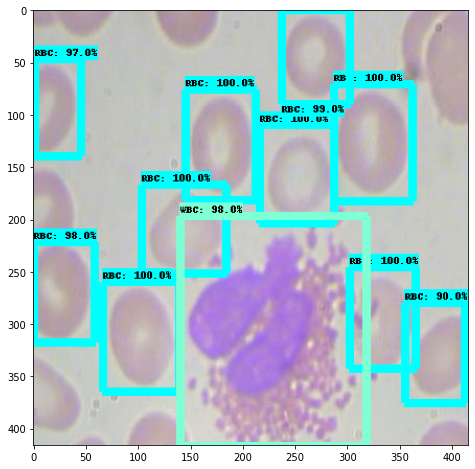

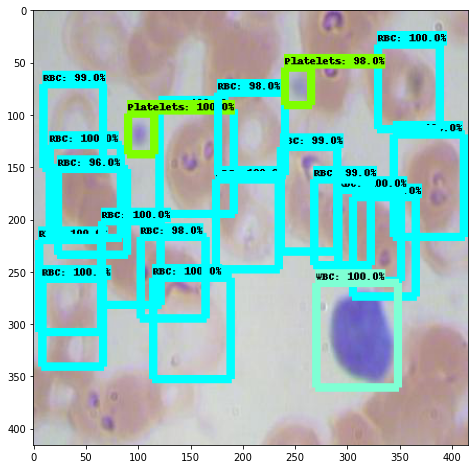

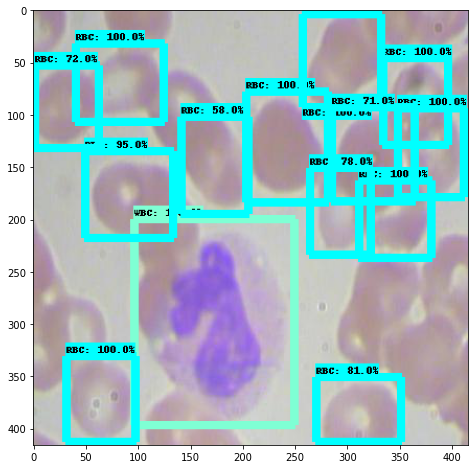

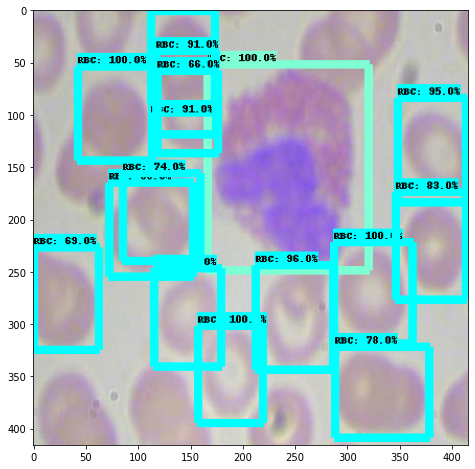

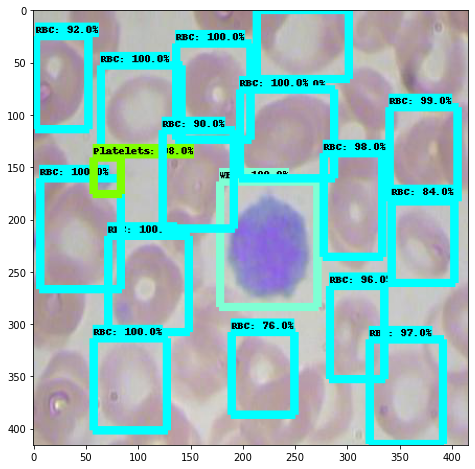

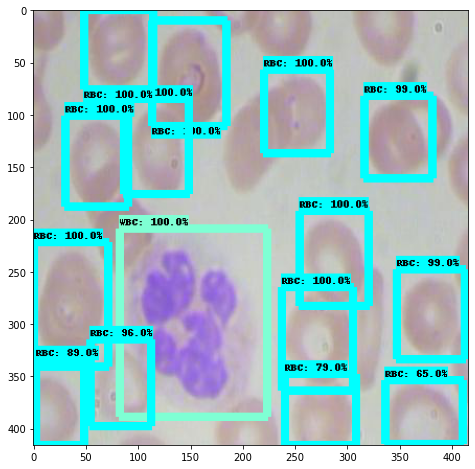

In [ ]:
# Limited displayed images to 5 to reduce memory
count = 5
for i, image_path in enumerate(TEST_IMAGE_PATHS):
    if i > count:
        break
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

# 3. Convert

With our model trained, it's time to convert our graph to .tflite!

In [ ]:
%ls /content/models/research/fine_tuned_model/tflite

tflite_graph.pb  tflite_graph.pbtxt


In [ ]:
!tflite_convert \
  --input_shape=1,300,300,3 \
  --input_arrays=normalized_input_image_tensor \
  --output_arrays=TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3 \
  --allow_custom_ops \
  --graph_def_file=/content/models/research/fine_tuned_model/tflite/tflite_graph.pb \
  --output_file="/content/models/research/fine_tuned_model/final_model.tflite"

2020-08-15 20:22:49.643606: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-08-15 20:22:49.648061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-08-15 20:22:49.648642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2020-08-15 20:22:49.648887: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-08-15 20:22:49.650331: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-08-15 20:22:49.654255: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Change the final TFLite destination here
!cp /content/models/research/fine_tuned_model/final_model.tflite "/content/drive/My Drive/"

Your TFLite file is now in your Drive as "final_model.tflite", ready to use with your project on-device! For specific device tutorials, check out the official TensorFlow Lite [Android Demo](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/android), [iOS Demo](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/ios), or [Raspberry Pi Demo](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi). [link text](https://)